In [1]:
from operator import itemgetter
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import zarr as zr

from vivarium.core.process import Process
import v2Ecoli.metab.cli as vmc

## Test installation

In [2]:
vmc.main(["test", "-t 30"])


Simulation ID: e7060b8e-0b6b-11f0-8bf5-23ddad3a62d8
Created: 03/27/2025 at 17:30:51
Completed in 6.27 seconds


## Simulate: Sensitivity to environment concentrations

In [3]:
model = vmc.find_model()
print(model)
time = 300
conc_factors = [1/3, 2/3, 1, 4/3, 5/3]
perturb_species = list(vmc.validate.IC_Variation._fields)

/vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/k-ecoli74.xml


In [4]:
proc, res = vmc.validate.simulate_vivarium(model, conc_factors, time)


Simulation ID: f2eb4a0e-0b6b-11f0-8f0e-23ddad3a62d8
Created: 03/27/2025 at 17:31:11
Completed in 70.51 seconds

Simulation ID: 1f59c276-0b6c-11f0-b76f-23ddad3a62d8
Created: 03/27/2025 at 17:32:25
Completed in 70.42 seconds

Simulation ID: 4bd56f4b-0b6c-11f0-b4a9-23ddad3a62d8
Created: 03/27/2025 at 17:33:40
Completed in 68.31 seconds

Simulation ID: 77082630-0b6c-11f0-9081-23ddad3a62d8
Created: 03/27/2025 at 17:34:52
Completed in 62.31 seconds

Simulation ID: 9eb1888f-0b6c-11f0-a4b5-23ddad3a62d8
Created: 03/27/2025 at 17:35:59
Completed in 63.60 seconds

Simulation ID: c70b3419-0b6c-11f0-a5e3-23ddad3a62d8
Created: 03/27/2025 at 17:37:07
Completed in 70.06 seconds

Simulation ID: f36a6e8a-0b6c-11f0-8608-23ddad3a62d8
Created: 03/27/2025 at 17:38:21
Completed in 72.12 seconds

Simulation ID: 20f7f5f9-0b6d-11f0-9dd9-23ddad3a62d8
Created: 03/27/2025 at 17:39:38
Completed in 69.26 seconds

Simulation ID: 4cd290d6-0b6d-11f0-bdaa-23ddad3a62d8
Created: 03/27/2025 at 17:40:51
Completed in 67.05 

## Storage

In [5]:
def to_datatree(proc: Process, result: vmc.validate.IC_Variation) -> xr.DataTree:
    assert isinstance(proc, Process)
    assert isinstance(result, vmc.validate.IC_Variation)    
    extract_emitted = lambda sp, f, dim: [
        list(map(itemgetter(dim), t)) for t in sp[f]["species_store"]]
    return xr.DataTree.from_dict({
        "/": xr.Dataset(
            coords={
                "species": proc.all_species},
            attrs={
                "model_file": str(proc.parameters["model_file"])}),
        "/simulation": xr.Dataset(
            coords={
                "perturb_species": perturb_species,
                "conc_factor": conc_factors},
            attrs={
                "time_step": proc.parameters["time_step"]}),
        "/simulation/timeseries": xr.Dataset(
            data_vars={
                "count": (
                    ("perturb_species", "conc_factor", "time", "species"),
                    [[extract_emitted(getattr(result, sp), f, 1) for f in conc_factors]
                     for sp in perturb_species])},
            coords={
                # if all simulations are statically known to have the same
                # time discretisation, then store as: coords["time"] = dims["time"]
                "time": (
                    ("perturb_species", "conc_factor", "time"),
                    [[getattr(result, sp)[f]["time"] for f in conc_factors]
                     for sp in perturb_species]),
                # check alignment with inherited coord, and then drop
                "species": itemgetter(0)(extract_emitted(
                    getattr(result, perturb_species[0]), conc_factors[0], 0))},
            ).drop_vars(["species"])})

In [6]:
trace = to_datatree(proc, res);
print(trace)
trace

<xarray.DataTree>
Group: /
│   Dimensions:  (species: 557)
│   Coordinates:
│     * species  (species) <U57 127kB '3PG' '6PG' ... 'bm_34_ENZ+His' 'bm_34_ENZ'
│   Attributes:
│       model_file:  /vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/k-ecoli74.xml
└── Group: /simulation
    │   Dimensions:          (perturb_species: 4, conc_factor: 5)
    │   Coordinates:
    │     * perturb_species  (perturb_species) <U6 96B 'Gluc_e' 'SO4_e' 'NH3_e' 'O2_e'
    │     * conc_factor      (conc_factor) float64 40B 0.3333 0.6667 1.0 1.333 1.667
    │   Attributes:
    │       time_step:  1.0
    └── Group: /simulation/timeseries
            Dimensions:          (perturb_species: 4, conc_factor: 5, time: 301,
                                  species: 557)
            Coordinates:
                time             (perturb_species, conc_factor, time) float64 48kB 0.0 .....
            Data variables:
                count            (perturb_species, conc_factor, time, species) float64 27MB ...


<xarray.DataTree>
Group: /
│   Dimensions:  (species: 557)
│   Coordinates:
│     * species  (species) <U57 127kB '3PG' '6PG' ... 'bm_34_ENZ+His' 'bm_34_ENZ'
│   Attributes:
│       model_file:  /vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/k-ecoli74.xml
└── Group: /simulation
    │   Dimensions:          (perturb_species: 4, conc_factor: 5)
    │   Coordinates:
    │     * perturb_species  (perturb_species) <U6 96B 'Gluc_e' 'SO4_e' 'NH3_e' 'O2_e'
    │     * conc_factor      (conc_factor) float64 40B 0.3333 0.6667 1.0 1.333 1.667
    │   Attributes:
    │       time_step:  1.0
    └── Group: /simulation/timeseries
            Dimensions:          (perturb_species: 4, conc_factor: 5, time: 301,
                                  species: 557)
            Coordinates:
                time             (perturb_species, conc_factor, time) float64 48kB 0.0 .....
            Data variables:
                count            (perturb_species, conc_factor, time, species) float64 27MB ...

In [7]:
store_path = f"./{Path(trace.attrs['model_file']).name.replace(".xml", ".zip")}"
store = zr.storage.ZipStore(store_path, mode="w")
trace.to_zarr(store)
store.close()

/opt/bitnami/python/lib/python3.13/zipfile/__init__.py:1643: UserWarning: Duplicate name: 'zarr.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/opt/bitnami/python/lib/python3.13/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/opt/bitnami/python/lib/python3.13/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `<U57` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/opt/bitnami/python/lib/python3.13/zipfile/__init__.py:1643: UserWarning: Duplicate name: 'species/zarr.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/opt/bitnami/python/lib/python3.13/zipfile/__init__.py:1643: UserWarning: Duplicate nam

## Visualisation

In [12]:
def plot_sensitivity(trace: xr.DataTree, plot_species=["Pyr", "ATP", "NADH", "Ac_e", "CO2_e"]):
    assert isinstance(trace, xr.DataTree)
    sim = trace["/simulation"]
    plt.rcParams["figure.dpi"] = 120
    fig = plt.figure(constrained_layout=True, figsize=(16, 12))
    plt.suptitle("Sensitivity to perturbations of external substrates", fontsize="x-large")
    subfigs = fig.subfigures(nrows=len(sim.conc_factor), ncols=1)
    for (i, (f, subfig)) in enumerate(zip(sim.conc_factor, subfigs)):
        subfig.supylabel(f"{f:.2f}x concentration", fontsize="large")
        axs = subfig.subplots(nrows=1, ncols=len(sim.perturb_species))
        for (j, (sp_s, ax)) in enumerate(zip(sim.perturb_species, axs)):
            traj = sim["timeseries"].sel(perturb_species=sp_s, conc_factor=f)
            for sp_p in (list(sim.perturb_species.to_numpy()) + plot_species):
                ax.plot(traj["time"].to_numpy(), traj["count"].sel(species=sp_p).to_numpy(),
                        ls='-', marker='o', markevery=20, label=sp_p)
            ax.grid(alpha=.3)
            if i == 0:
                ax.set_title(f"Perturbation: {sp_s.item()}", fontsize="large")
            if i == list(sim.conc_factor).index(1):
                ax.legend(loc="center left", fontsize="small")
            if i == len(sim.conc_factor) - 1:
                ax.set_xlabel("Time (s)")
            if j == 0:
                ax.set_ylabel("Metabolites (mol)")
    plt.show()

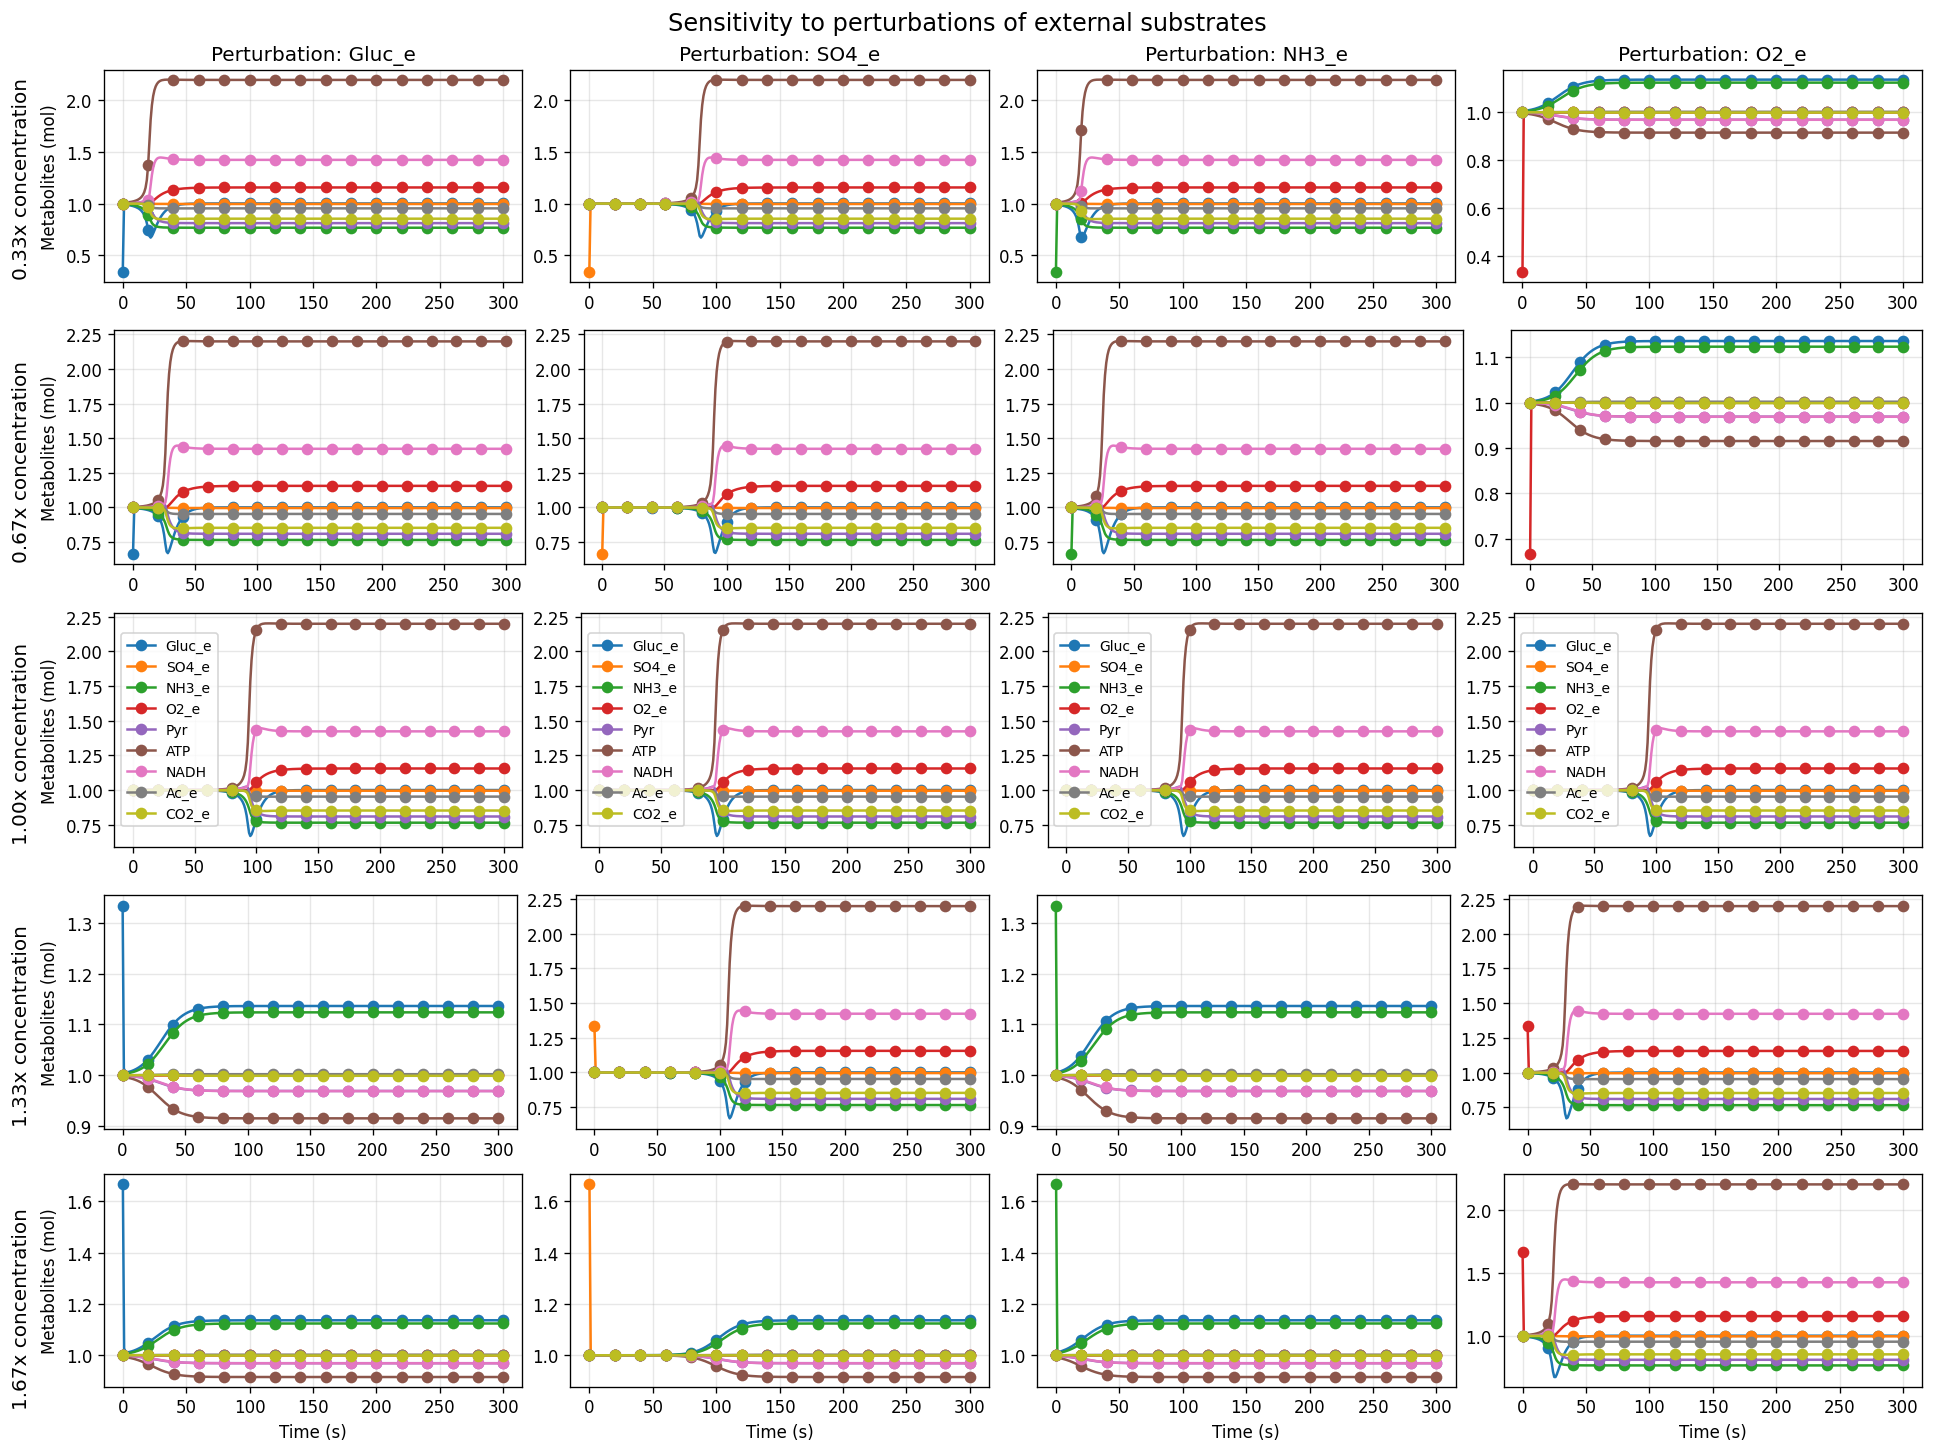

In [13]:
plot_sensitivity(trace)